Run summary analysis on pseudocausal broad outcomes from the Snakemake pipeline.

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import logit

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.utils import concat_csv_with_indices

In [132]:
evaluation = "matches_next_phoneme"
measure = "target_rank"

In [118]:
results_df = concat_csv_with_indices(
    "outputs/analogy_pseudocausal_broad/runs/*/*/*/*/*/*/experiment_results.csv",
    [lambda p: p.parents[0].name, lambda p: p.parents[1].name, lambda p: p.parents[2].name,
            lambda p: p.parents[3].name, lambda p: p.parents[4].name, lambda p: p.parents[5].name],
    ["test_dataset", "evaluation", "equivalence", "model", "base_model", "train_dataset"],
).droplevel(-1).reset_index()

In [127]:
# metadata
results_df["inflection_from_clean"] = results_df.inflection_from.str.split("-").str[-1]
results_df["inflection_to_clean"] = results_df.inflection_to.str.split("-").str[-1]
# control trials have mismatched source--target; this establishes a baseline success rate
results_df["control"] = results_df.inflection_from_clean != results_df.inflection_to_clean

In [120]:
trace_keys = ["base_model", "model", "train_dataset", "equivalence", "test_dataset", "evaluation"]

In [121]:
def compute_advantage(group, evaluation="matches_next_phoneme", measure="target_rank"):
    df = group.groupby(["control", "inflection_from_clean", "to_base_phones"])[f"{evaluation}_{measure}"].mean()
    advantage = df.loc[True] - df.loc[False]
    advantage = advantage.rename(f"{evaluation}_{measure}_advantage").dropna().reset_index()
    return advantage

In [133]:
all_advantages = results_df.groupby(trace_keys).apply(compute_advantage)
all_advantages.groupby(trace_keys)[f"{evaluation}_{measure}_advantage"].mean().sort_values()

/tmp/ipykernel_1048722/3521161532.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_advantages = results_df.groupby(trace_keys).apply(compute_advantage)


base_model  model            train_dataset                equivalence                     test_dataset                 evaluation  
w2v2_pc_8   ffff_32-pc-mAP1  librispeech-train-clean-100  word_broad_10frames_fixedlen25  librispeech-train-clean-100  phoneme_at_2    3809.279683
Name: matches_next_phoneme_target_rank_advantage, dtype: float64

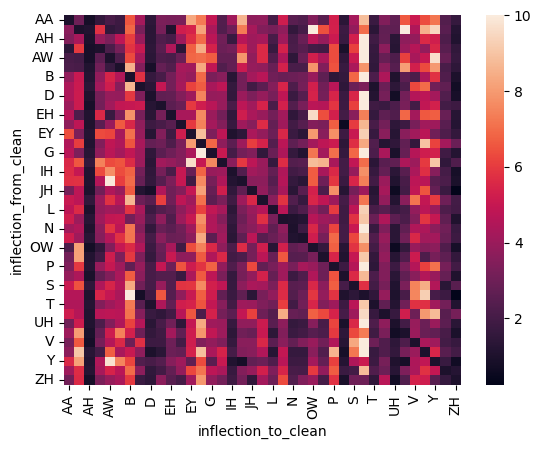

In [157]:
for trace, group in results_df.groupby(trace_keys):
    rank_heatmap_df = group.groupby(["inflection_from_clean", "inflection_to_clean"])[f"{evaluation}_{measure}"].mean().unstack()
    # normalize: divide columnwise by diagonal
    rank_heatmap_df = rank_heatmap_df.div(np.diag(rank_heatmap_df), axis=1)
    rank_heatmap_df = np.clip(rank_heatmap_df, -np.inf, 10)
    sns.heatmap(rank_heatmap_df)

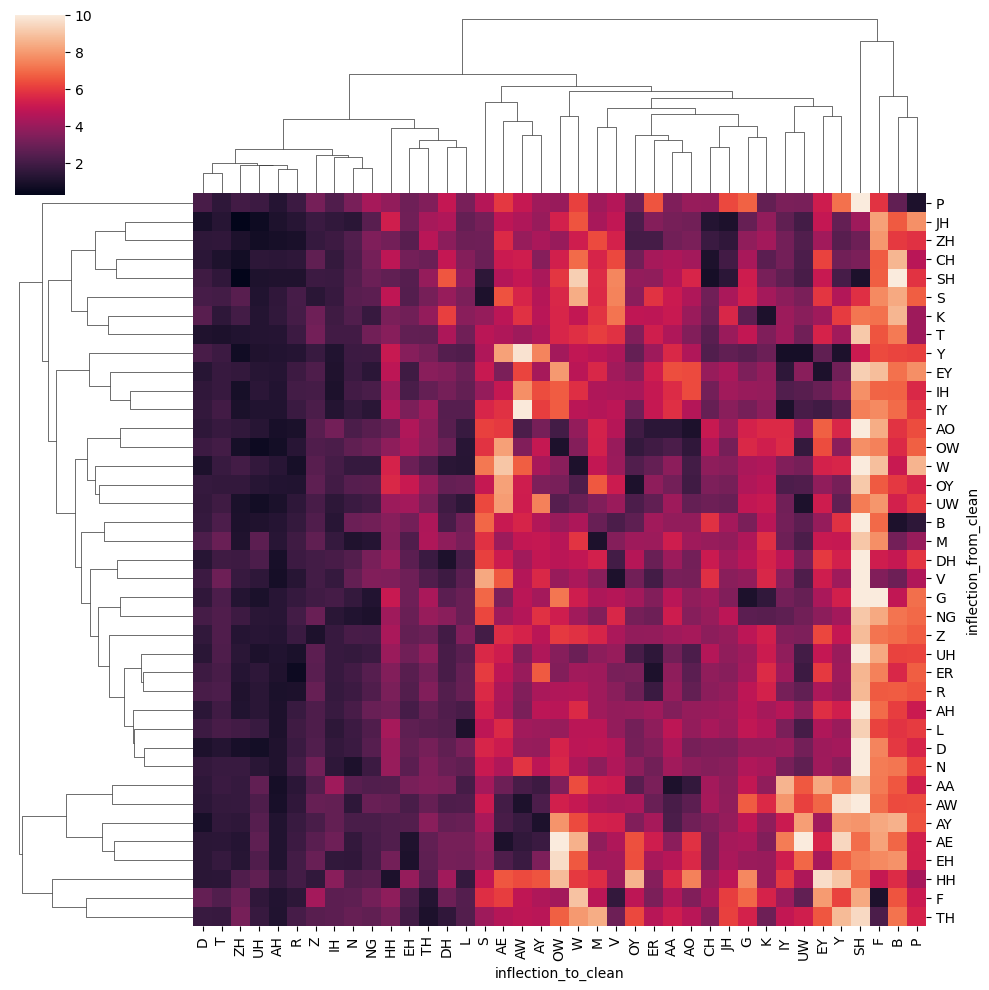

In [158]:
sns.clustermap(rank_heatmap_df)

In [6]:
path = "outputs/analogy_pseudocausal_broad/runs/librispeech-train-clean-100/w2v2_pc_8/ffff_32-pc-mAP1/word_broad_10frames_fixedlen25/phoneme_at_2/librispeech-train-clean-100/experiment_results.csv"

In [7]:
word_freq_df = pd.read_csv("data/WorldLex_Eng_US.Freq.2.txt", sep="\t", index_col="Word")
word_freq_df = word_freq_df.loc[~word_freq_df.index.duplicated()]
# compute weighted average frequency across domains
word_freq_df["BlogFreq_rel"] = word_freq_df.BlogFreq / word_freq_df.BlogFreq.sum()
word_freq_df["TwitterFreq_rel"] = word_freq_df.TwitterFreq / word_freq_df.TwitterFreq.sum()
word_freq_df["NewsFreq_rel"] = word_freq_df.NewsFreq / word_freq_df.NewsFreq.sum()
word_freq_df["Freq"] = word_freq_df[["BlogFreq_rel", "TwitterFreq_rel", "NewsFreq_rel"]].mean(axis=1) \
    * word_freq_df[["BlogFreq", "TwitterFreq", "NewsFreq"]].sum().mean()
word_freq_df["LogFreq"] = np.log10(word_freq_df.Freq)

In [8]:
df = pd.read_csv(path)

In [9]:
df["to_base_phones"] = df.to_base_phones.fillna("")
df["from_base_phones"] = df.from_base_phones.fillna("")

In [10]:
# merge in frequency information
df = pd.merge(df, word_freq_df.LogFreq.rename("from_freq"),
              left_on="from", right_index=True)
df = pd.merge(df, word_freq_df.LogFreq.rename("to_freq"),
                left_on="to", right_index=True)

In [11]:
evaluations = [re.findall("(.+)_target_rank", col)[0] for col in df.columns if col.endswith("_target_rank")]
evaluations

['matches_next_phoneme',
 'matches_next_phoneme_weak',
 'matches_cohort',
 'matches_cohort_and_next_phoneme',
 'matches_cohort_and_next_phoneme_weak']

In [12]:
cohort_length = df.to_base_phones.iloc[0].count(" ") + 1 if df.to_base_phones.iloc[0] != "" else 0
assert df.to_base_phones.str.count(" ").unique().tolist() == [max(0, cohort_length - 1)]
assert df.from_base_phones.str.count(" ").unique().tolist() == [max(0, cohort_length - 1)]

In [13]:
# metadata
# control trials have mismatched source--target; this establishes a baseline success rate
df["control"] = df.inflection_to.str.split("-").str[-1] != df.inflection_from.str.split("-").str[-1]
# small cohort vs large cohort experiment
df["is_small_experiment"] = df.experiment.str.contains("to-small-")
df["inflection_from_clean"] = df.inflection_from.str.split("-").str[-1]
df["inflection_to_clean"] = df.inflection_to.str.split("-").str[-1]

for evaluation in evaluations:
    df[f"{evaluation}_correct"] = df[f"{evaluation}_target_rank"] == 0

# oops, these are redundantly recorded for all evaluations. just grab one
predicted_columns = ["predicted_phones", "predicted_phoneme_idx",
                     "predicted_label", "predicted_instance_idx"]
for col in predicted_columns:
    df[col] = df[f"{evaluations[0]}_{col}"]

# extract predicted phone
def get_predicted_phone(row):
    predicted_phones = row.predicted_phones.split(" ")
    predicted_phone_idx = cohort_length
    if len(predicted_phones) - 1 < predicted_phone_idx:
        return None
    return predicted_phones[predicted_phone_idx]
df["predicted_phone"] = df.apply(get_predicted_phone, axis=1)

## Prepare cohort statistics

In [15]:
cohort_types = pd.concat([
    df.groupby("from_base_phones").apply(lambda xs: xs.drop_duplicates("from")[["from"]]).rename(columns={"from": "word"}),
    df.groupby("to_base_phones").apply(lambda xs: xs.drop_duplicates("to")[["to"]]).rename(columns={"to": "word"})
])
if len(cohort_types.index.names) == 2:
    cohort_types = cohort_types.droplevel(-1)
cohort_types.index.names = ["base_phones"]

/tmp/ipykernel_1048722/4060686325.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("from_base_phones").apply(lambda xs: xs.drop_duplicates("from")[["from"]]).rename(columns={"from": "word"}),
/tmp/ipykernel_1048722/4060686325.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("to_base_phones").apply(lambda xs: xs.drop_duplicates("to")[["to"]]).rename(columns={"to": "word"})


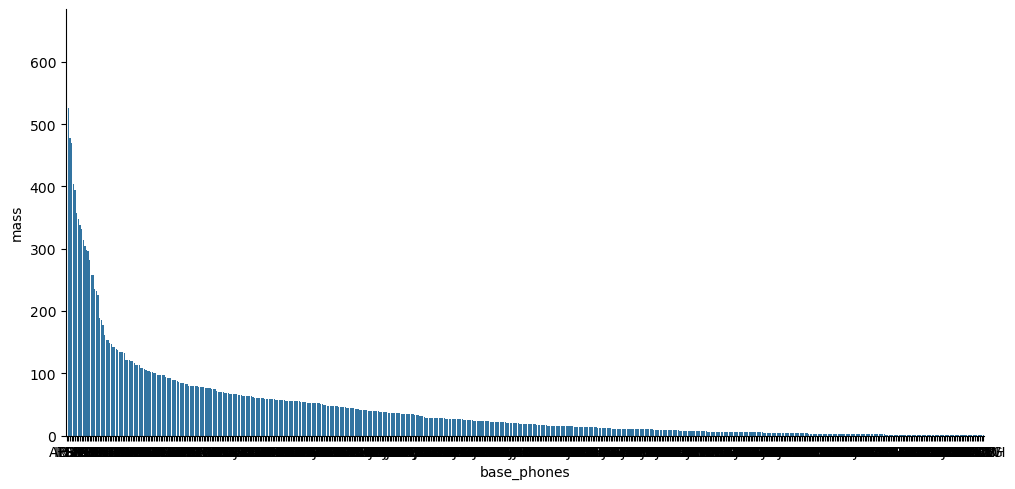

In [22]:
cohort_type_mass = cohort_types.groupby("base_phones").size().rename("mass")
sns.catplot(data=cohort_type_mass.reset_index(), x="base_phones", y="mass",
            order=cohort_types.groupby("base_phones").size().sort_values(ascending=False).index,
            kind="bar", aspect=2)

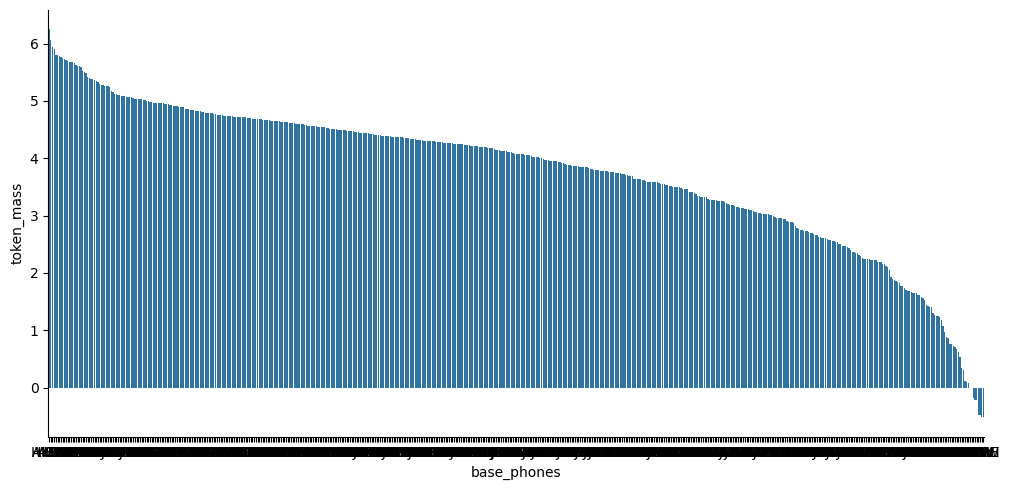

In [24]:
cohort_token_mass = np.log10(cohort_types.groupby("base_phones").apply(lambda xs: word_freq_df.loc[xs.word].Freq.sum())).rename("token_mass")
sns.catplot(data=cohort_token_mass.reset_index(), x="base_phones", y="token_mass",
            order=cohort_types.groupby("base_phones").apply(lambda xs: word_freq_df.loc[xs.word].Freq.sum()).sort_values(ascending=False).index,
            kind="bar", aspect=2)

In [26]:
df = pd.merge(df, cohort_type_mass.rename("from_cohort_type_mass"),
              left_on="from_base_phones", right_index=True)
df = pd.merge(df, cohort_type_mass.rename("to_cohort_type_mass"),
              left_on="to_base_phones", right_index=True)
df = pd.merge(df, cohort_token_mass.rename("from_cohort_token_mass"),
              left_on="from_base_phones", right_index=True)
df = pd.merge(df, cohort_token_mass.rename("to_cohort_token_mass"),
              left_on="to_base_phones", right_index=True)

## Summarize

In [27]:
df.head()

,experiment,Unnamed: 1,matches_next_phoneme_target_rank,matches_next_phoneme_target_distance,matches_next_phoneme_target_label_idx,matches_next_phoneme_target_instance_idx,matches_next_phoneme_target_phoneme_idx,matches_next_phoneme_target_label,matches_next_phoneme_target_phones,matches_next_phoneme_predicted_distance,...,matches_cohort_and_next_phoneme_weak_correct,predicted_phones,predicted_phoneme_idx,predicted_label,predicted_instance_idx,predicted_phone,from_cohort_type_mass,to_cohort_type_mass,from_cohort_token_mass,to_cohort_token_mass
0,ctf-F_AH N_F,0,17,0.283487,11547,0,2,infamous,IH N F AH M AH S,0.232028,...,False,AH N OY Z,1,annoys,0,OY,70,652,4.442429,6.248988
1,ctf-F_AH N_F,1,0,0.200405,10109,23,2,unfortunate,AH N F AO R CH AH N AH T,0.200405,...,True,AH N F AO R CH AH N AH T,2,unfortunate,23,F,652,652,6.248988,6.248988
2,ctf-F_AH N_F,2,850,0.347500,23229,0,2,unfaltering,AH N F AH L T ER IH NG,0.209062,...,False,AH N IY V EH N T F AH L,1,uneventful,0,IY,46,652,3.796041,6.248988
3,ctf-F_AH N_F,3,37,0.547257,15306,0,2,unfeign'd,AH N F EY N D,0.510553,...,False,AE F T ER N UW N,6,afternoon,75,T,332,652,5.713777,6.248988
4,ctf-F_AH N_F,4,0,0.168721,13025,1,2,unfolding,AH N F OW L D IH NG,0.168721,...,True,AH N F OW L D IH NG,2,unfolding,1,F,652,652,6.248988,6.248988


In [28]:
all_phones = set(df.inflection_from_clean.values) | set(df.inflection_to_clean.values)
all_phones

{'AA',
 'AE',
 'AH',
 'AO',
 'AW',
 'AY',
 'B',
 'CH',
 'D',
 'DH',
 'EH',
 'ER',
 'EY',
 'F',
 'G',
 'HH',
 'IH',
 'IY',
 'JH',
 'K',
 'L',
 'M',
 'N',
 'NG',
 'OW',
 'OY',
 'P',
 'R',
 'S',
 'SH',
 'T',
 'TH',
 'UH',
 'UW',
 'V',
 'W',
 'Y',
 'Z',
 'ZH'}

In [29]:
main_results = df[~df.is_small_experiment]
small_results = df[df.is_small_experiment]

In [30]:
main_results

,experiment,Unnamed: 1,matches_next_phoneme_target_rank,matches_next_phoneme_target_distance,matches_next_phoneme_target_label_idx,matches_next_phoneme_target_instance_idx,matches_next_phoneme_target_phoneme_idx,matches_next_phoneme_target_label,matches_next_phoneme_target_phones,matches_next_phoneme_predicted_distance,...,matches_cohort_and_next_phoneme_weak_correct,predicted_phones,predicted_phoneme_idx,predicted_label,predicted_instance_idx,predicted_phone,from_cohort_type_mass,to_cohort_type_mass,from_cohort_token_mass,to_cohort_token_mass
0,ctf-F_AH N_F,0,17,0.283487,11547,0,2,infamous,IH N F AH M AH S,0.232028,...,False,AH N OY Z,1,annoys,0,OY,70,652,4.442429,6.248988
1,ctf-F_AH N_F,1,0,0.200405,10109,23,2,unfortunate,AH N F AO R CH AH N AH T,0.200405,...,True,AH N F AO R CH AH N AH T,2,unfortunate,23,F,652,652,6.248988,6.248988
2,ctf-F_AH N_F,2,850,0.347500,23229,0,2,unfaltering,AH N F AH L T ER IH NG,0.209062,...,False,AH N IY V EH N T F AH L,1,uneventful,0,IY,46,652,3.796041,6.248988
3,ctf-F_AH N_F,3,37,0.547257,15306,0,2,unfeign'd,AH N F EY N D,0.510553,...,False,AE F T ER N UW N,6,afternoon,75,T,332,652,5.713777,6.248988
4,ctf-F_AH N_F,4,0,0.168721,13025,1,2,unfolding,AH N F OW L D IH NG,0.168721,...,True,AH N F OW L D IH NG,2,unfolding,1,F,652,652,6.248988,6.248988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701993,ctf-JH_W IH_DH,43,289,0.394297,31275,1,2,wutherspoon,W AH DH ER S P UW N,0.317122,...,False,W IH L,1,will,40,L,122,305,4.825764,6.062298
701995,ctf-JH_W IH_DH,45,541,0.343951,237,34,2,without,W IH DH AW T,0.251403,...,False,W IH TH,1,with,18,TH,82,305,4.642838,6.062298
701996,ctf-JH_W IH_DH,46,805,0.216538,237,34,2,without,W IH DH AW T,0.086452,...,False,W IH N Z,1,wins,0,N,469,305,5.724652,6.062298
701997,ctf-JH_W IH_DH,47,56,0.274613,2723,5,2,whither,W IH DH ER,0.221944,...,False,W IH SH IH NG,1,wishing,47,SH,134,305,4.856876,6.062298


## Summary plots

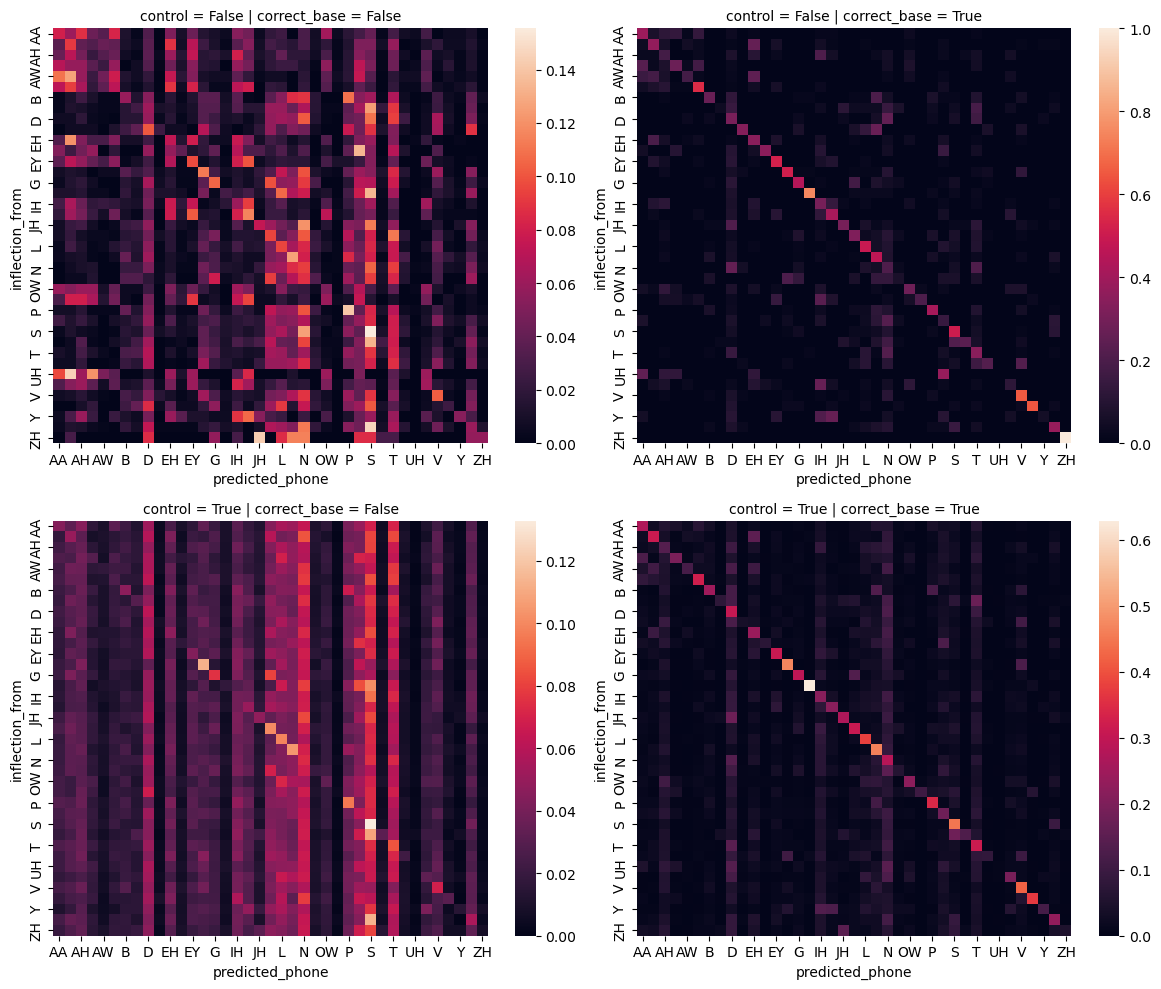

In [31]:
heatmap_results = main_results.groupby(["control", "matches_cohort_correct", "inflection_from"]) \
    .predicted_phone.value_counts(normalize=True) \
    .reindex(pd.MultiIndex.from_product(
        [[False, True], [False, True], sorted(all_phones), sorted(all_phones)],
        names=["control", "correct_base", "inflection_from", "predicted_phone"])) \
    .fillna(0)

plot_all_phones = False
g = sns.FacetGrid(data=heatmap_results.reset_index(), row="control", col="correct_base", height=5, aspect=2 if plot_all_phones else 1.2, sharex=False, sharey=False)
def f(data, **kwargs):
    sns.heatmap(data.pivot_table(index="inflection_from", columns="predicted_phone", values="proportion").reindex(sorted(all_phones), axis=1))
g.map_dataframe(f, annot=True, cmap="Blues")

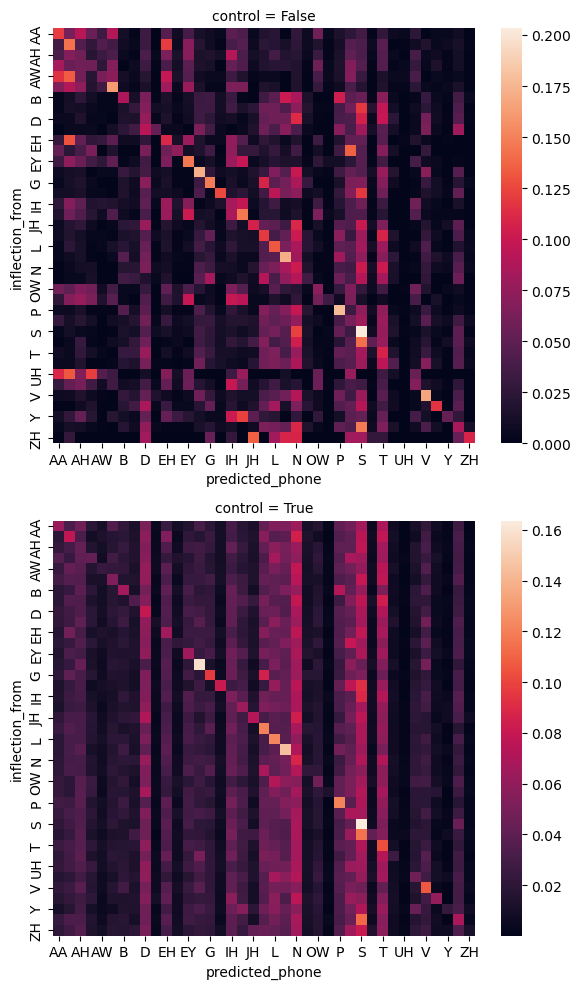

In [32]:
heatmap_results = main_results.groupby(["control", "inflection_from"]) \
    .predicted_phone.value_counts(normalize=True) \
    .reindex(pd.MultiIndex.from_product(
        [[False, True], sorted(all_phones), sorted(all_phones)],
        names=["control", "inflection_from", "predicted_phone"])) \
    .fillna(0)

plot_all_phones = False
g = sns.FacetGrid(data=heatmap_results.reset_index(), row="control", height=5, aspect=2 if plot_all_phones else 1.2, sharex=False, sharey=False)
def f(data, **kwargs):
    sns.heatmap(data.pivot_table(index="inflection_from", columns="predicted_phone", values="proportion").reindex(sorted(all_phones), axis=1))
g.map_dataframe(f, annot=True, cmap="Blues")

In [45]:
df.groupby(["control", "is_small_experiment", "to_base_phones"]).matches_next_phoneme_target_distance.mean().loc[False].sort_values()

is_small_experiment  to_base_phones
False                P R               0.234052
                     B R               0.254430
                     S IH              0.264451
                     K AH              0.271238
                     D R               0.272779
                     M EH              0.273102
                     S EH              0.281380
                     R IY              0.284861
                     R IH              0.286634
                     S T               0.292833
                     S AH              0.295397
                     G R               0.295495
                     W IH              0.296390
                     S P               0.299269
                     T R               0.299673
                     HH AE             0.309913
                     IH N              0.320961
                     B IH              0.322148
                     D IH              0.327674
                     AH N              0.350772
Name

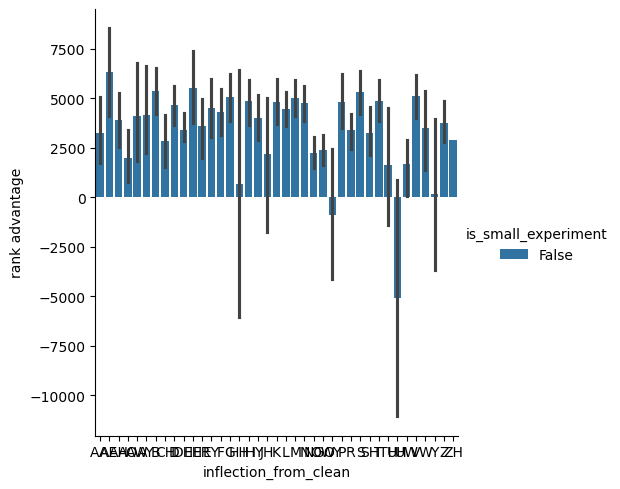

In [60]:
advantage_df = df.groupby(["control", "is_small_experiment", "inflection_from_clean", "to_base_phones"]).matches_next_phoneme_target_rank.mean()
advantage_df = advantage_df.loc[True] - advantage_df.loc[False]
advantage_df = advantage_df.rename("rank advantage").dropna().reset_index()
sns.catplot(data=advantage_df, x="inflection_from_clean", y="rank advantage", hue="is_small_experiment", kind="bar")

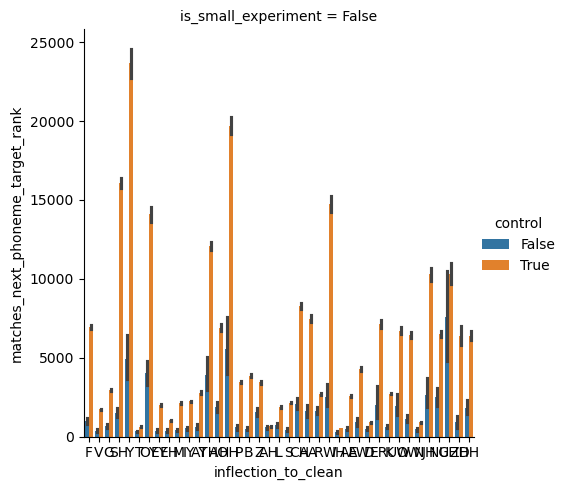

In [47]:
sns.catplot(data=df,
            x="inflection_to_clean",
            y="matches_next_phoneme_target_rank",
            hue="control", col="is_small_experiment",
            kind="bar")

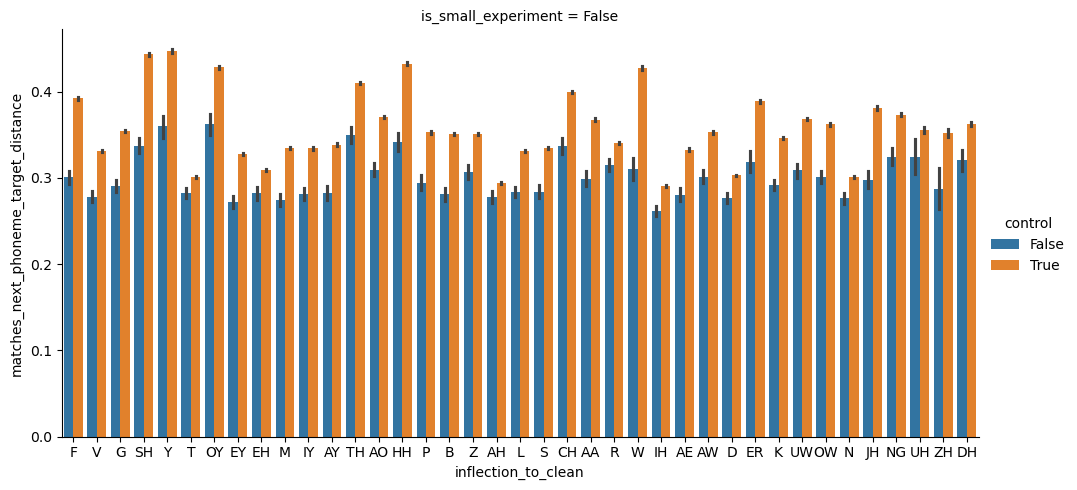

In [62]:
sns.catplot(data=df,
            x="inflection_to_clean",
            y="matches_next_phoneme_target_distance",
            hue="control", col="is_small_experiment",
            kind="bar", aspect=2)

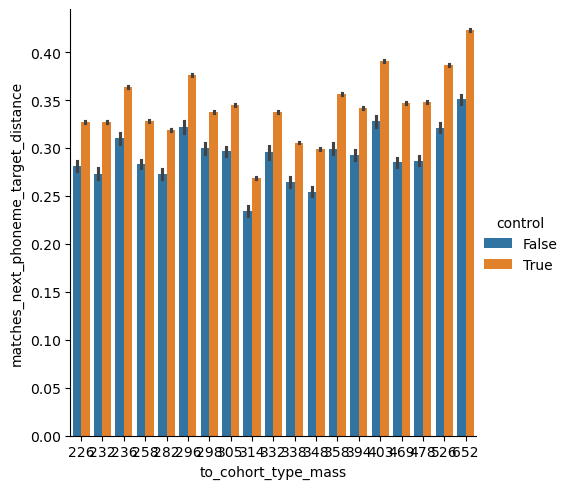

In [63]:
sns.catplot(data=df,
              x="to_cohort_type_mass", y="matches_next_phoneme_target_distance", hue="control", kind="bar")

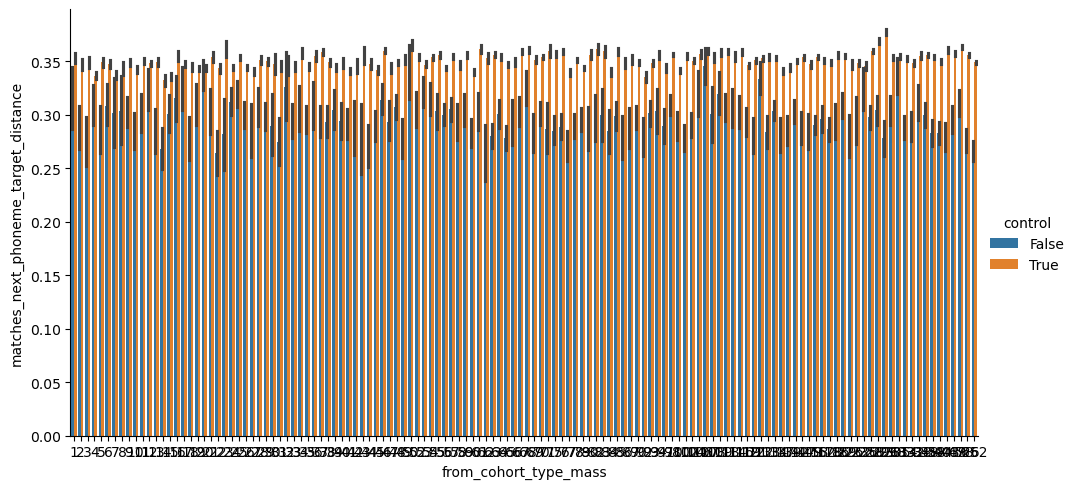

In [70]:
sns.catplot(data=df,
              x="from_cohort_type_mass", y="matches_next_phoneme_target_distance", hue="control", kind="bar", aspect=2)

## Rank results

In [71]:
df.groupby("control").sample(2)[["control", "inflection_from_clean", "inflection_to_clean", "from_base_phones", "to_base_phones", "matches_next_phoneme_target_phones"]]

,control,inflection_from_clean,inflection_to_clean,from_base_phones,to_base_phones,matches_next_phoneme_target_phones
122356,False,T,T,S EH,S IH,S IH T IY
333091,False,B,B,AY S,M EH,M EY B AH L
284179,True,AO,V,F R,S IH,S IH V AH L AY Z D
97690,True,Y,ER,AH B,IH N,EH N ER JH IY


In [108]:
rank_heatmap_df = df.groupby(["inflection_from_clean", "inflection_to_clean"]).matches_next_phoneme_target_rank.mean().unstack("inflection_to_clean")

In [109]:
rank_heatmap_df

inflection_to_clean,AA,AE,AH,AO,AW,AY,B,CH,D,DH,...,SH,T,TH,UH,UW,V,W,Y,Z,ZH
inflection_from_clean,,,,,,,,,,,,,,,,,,,,,
AA,1613.230435,1401.359477,482.288382,2893.714912,1734.627841,968.389041,4030.056054,9924.029613,817.695271,6612.549133,...,15807.446469,617.772329,12968.257471,20425.292135,13022.412946,1992.734440,18255.705357,33744.435754,3291.635108,7128.000000
AE,6363.394860,490.716814,661.106122,10162.422907,1409.701370,1072.231429,4152.849188,7103.748315,798.024735,6823.063584,...,12415.640091,471.679376,9510.503480,15897.271739,22777.700441,1753.034413,24278.943723,45718.129032,3648.936902,5104.347826
AH,6625.077803,2102.408676,586.268344,7220.983908,3127.694611,2722.892857,3702.132118,8827.028302,795.869403,4653.302326,...,17870.141176,656.102888,10360.988399,8997.387097,7510.820755,1464.594017,15503.682243,24177.251429,3276.839286,4530.292683
AO,2548.267857,2972.031461,538.542857,1864.779476,1930.312849,2008.073239,3626.456422,11420.470183,815.463972,5217.103825,...,18586.870670,582.302867,13601.905963,8653.033333,7693.822222,1794.360996,9903.143498,25939.248619,3588.113462,5359.756098
AW,3778.304239,1023.533487,484.804444,4727.853012,916.500000,1397.125392,3820.002445,9829.935961,746.288425,4621.387500,...,17694.627160,536.618868,10250.639024,16268.202381,12343.636580,1724.392377,12310.653659,45767.142857,4089.039583,6422.000000
AY,4021.404922,1031.258503,624.057377,5621.750000,1515.086351,629.108635,5278.654378,8146.250000,492.732865,5767.644809,...,14178.380744,507.713787,13572.101996,16458.864583,15588.354978,2033.411178,17671.707207,39282.430108,3105.032258,5804.638889
B,7116.823389,2350.555288,698.074398,7191.062350,4873.471471,2851.448598,494.168675,13093.236407,950.449438,4059.218750,...,28978.951574,782.118199,15904.639024,7610.604651,5257.631325,789.369330,10915.971564,28850.443750,3364.865031,4396.250000
CH,7965.146226,2458.558897,722.718468,7862.831707,4355.548780,2213.951220,5335.397959,2054.034653,802.004008,11017.580645,...,5689.338346,343.544732,10997.503704,9284.617978,4482.261728,2369.709821,17621.882927,14821.425287,3930.557851,3849.470588
D,7744.888095,2481.260563,619.189362,6117.407674,3620.737892,2088.329446,3654.834532,7823.431604,504.003738,4930.335260,...,18676.834928,413.964880,11138.367299,4709.244186,5581.139269,1693.015590,13041.680556,20526.982558,3477.660679,4275.710526


<Axes: xlabel='inflection_to_clean', ylabel='inflection_from_clean'>

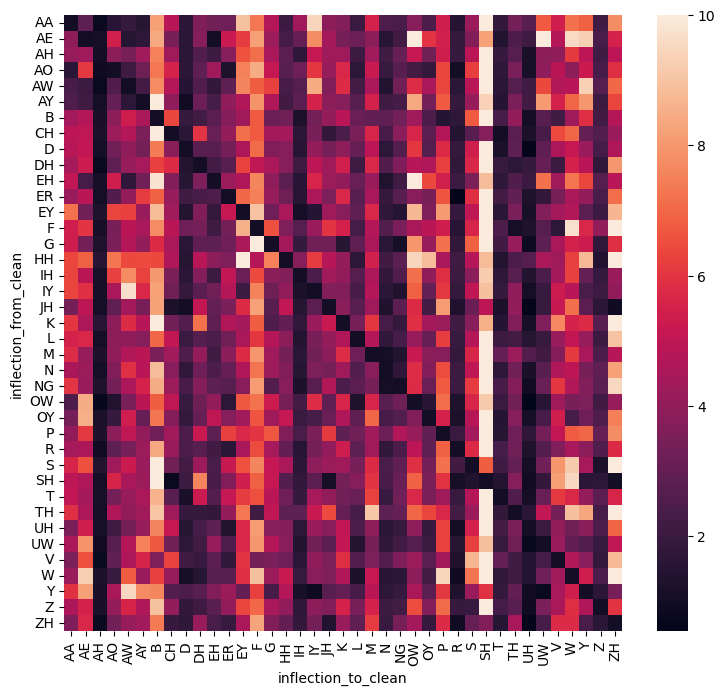

In [110]:
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(np.clip(rank_heatmap_df.div(np.diag(rank_heatmap_df), axis=1), a_min=-np.inf, a_max=10))

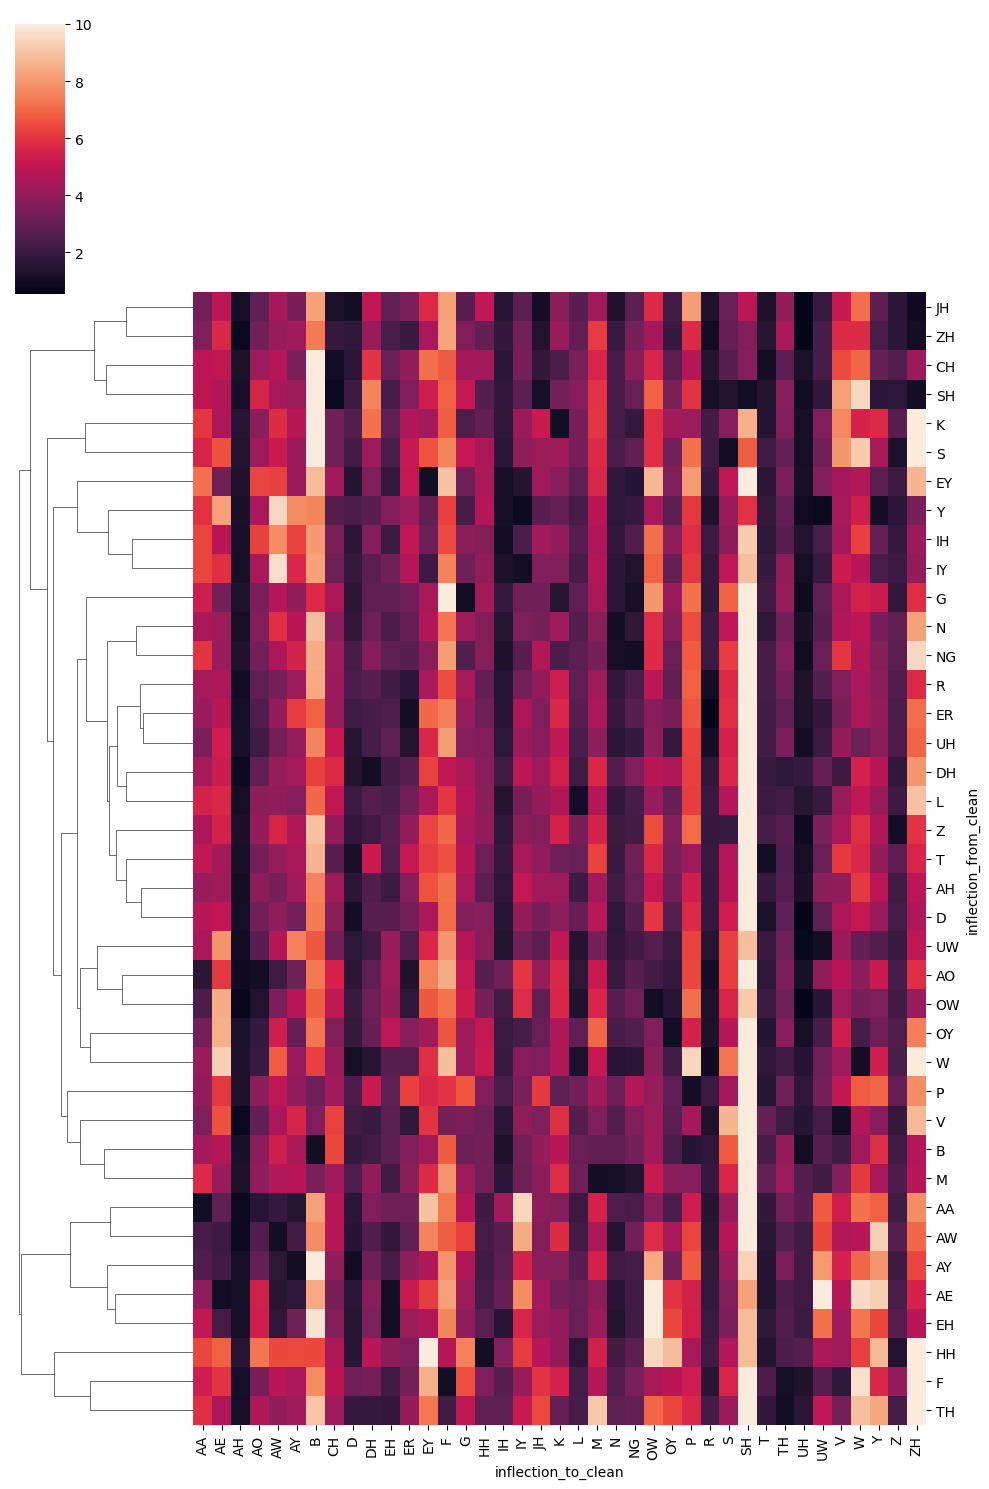

In [111]:
sns.clustermap(np.clip(rank_heatmap_df.div(np.diag(rank_heatmap_df), axis=1), a_min=-np.inf, a_max=10), figsize=(10, 15), col_cluster=False)

TODO how to summarize?

- rank advantage distribution



## etc

In [31]:
df.query("not control").groupby("to").matches_next_phoneme_target_rank.agg(["mean", "std", "count"]).query("count > 15").sort_values("std").head(20)

,mean,std,count
to,,,
colon,0.588235,0.870260,17
rosary,0.736842,0.991189,19
fool,0.535714,1.061119,56
fooling,1.017857,1.070107,56
rosebud,0.789474,1.474937,19
arrangement,0.818182,1.685500,33
payne,1.863636,1.698612,22
unmitigated,1.913043,1.755848,23
rosebuds,0.947368,1.778691,19


In [32]:
df.query("not control").groupby("to").matches_next_phoneme_target_rank.agg(["mean", "std", "count"]).query("count > 15").sort_values("std").tail(20)

,mean,std,count
to,,,
coexistence,432.115385,453.456532,26
augmenting,264.120690,455.585379,58
lilacs,336.187500,472.991645,16
permeated,280.052632,490.496967,19
rowing,298.666667,503.149271,24
unnoticed,291.000000,550.071107,19
coalitions,415.476190,574.741561,21
untrained,402.388889,578.588357,18
unsettled,318.823529,592.984531,17


In [38]:
pd.merge(df.query("not control and inflection_from == 'D'").groupby("from").matches_next_phoneme_target_rank.agg(["median", "mean", "std", "count"]).query("count > 15").sort_values("median"),
         word_freq_df.LogFreq, left_index=True, right_index=True).head(10)

,median,mean,std,count,LogFreq
perdition,2.0,21.967742,64.625322,31,0.670286
production,2.0,3.576923,4.051401,26,3.394372
undergo,3.0,43.000000,105.007584,28,2.231033
rhododendron,3.0,36.592593,97.084127,27,1.048346
undoubtedly,3.5,48.187500,171.374978,32,2.300736
lied,5.5,68.035714,140.179114,28,2.552530
productive,6.0,30.653846,50.154914,26,2.991812
undergoing,6.0,104.258065,357.983330,31,2.159069
paid,7.0,27.225806,58.321357,31,3.590611
underlying,9.0,55.866667,166.732851,30,2.380022


In [39]:
pd.merge(df.query("not control and inflection_from == 'D'").groupby("from").matches_next_phoneme_target_rank.agg(["median", "mean", "std", "count"]).query("count > 15").sort_values("median"),
         word_freq_df.LogFreq, left_index=True, right_index=True).tail(10)

,median,mean,std,count,LogFreq
and,20.0,539.200000,1451.592488,25,5.896227
roadway,21.0,40.653846,78.827885,26,2.022977
road,23.5,111.375000,230.843859,32,3.866196
codicil,24.0,123.035714,399.867893,28,-0.216106
kodak,25.0,163.678571,408.801052,28,2.071057
roads,27.0,282.375000,983.188549,24,2.961720
curdling,28.0,239.000000,759.201250,27,0.814884
roadster,40.0,126.958333,294.113920,24,1.142710
rode,44.0,233.357143,724.433838,28,2.523003
roadside,47.0,94.037037,159.131412,27,2.112701


In [41]:
pd.merge(df.query("not control and inflection_to == 'D'").groupby("from").matches_next_phoneme_target_distance.agg(["median", "mean", "std", "count"]).query("count > 15").sort_values("median"),
         word_freq_df.LogFreq, left_index=True, right_index=True).head(10)

,median,mean,std,count,LogFreq
undergo,0.067653,0.092690,0.058671,22,2.231033
rhode,0.069447,0.089794,0.059496,27,2.143866
codicil,0.072398,0.090865,0.064995,22,-0.216106
kurdish,0.073149,0.098365,0.060220,20,1.409849
underlying,0.074130,0.099968,0.064991,24,2.380022
curdling,0.074482,0.093291,0.063115,21,0.814884
pedro,0.078628,0.110068,0.070269,25,2.177209
understands,0.079775,0.106801,0.065756,28,2.662461
cordite,0.080554,0.109880,0.069443,26,0.261015
cody,0.081670,0.106481,0.066421,23,2.685254


In [42]:
pd.merge(df.query("not control and inflection_to == 'D'").groupby("from").matches_next_phoneme_target_distance.agg(["median", "mean", "std", "count"]).query("count > 15").sort_values("median"),
         word_freq_df.LogFreq, left_index=True, right_index=True).tail(10)

,median,mean,std,count,LogFreq
rode,0.106850,0.123691,0.057878,22,2.523003
undergoing,0.108141,0.119946,0.068893,25,2.159069
payed,0.108458,0.119456,0.048925,18,1.457476
understood,0.109310,0.127665,0.062421,22,2.906573
undoubtedly,0.129867,0.138908,0.060257,26,2.300736
productive,0.132001,0.137093,0.043838,20,2.991812
perdition,0.134793,0.133282,0.042532,25,0.670286
roadway,0.135202,0.138755,0.076270,20,2.022977
road,0.144739,0.144882,0.069212,26,3.866196
and,0.157001,0.183351,0.090559,19,5.896227


<Axes: xlabel='std', ylabel='type_mass'>

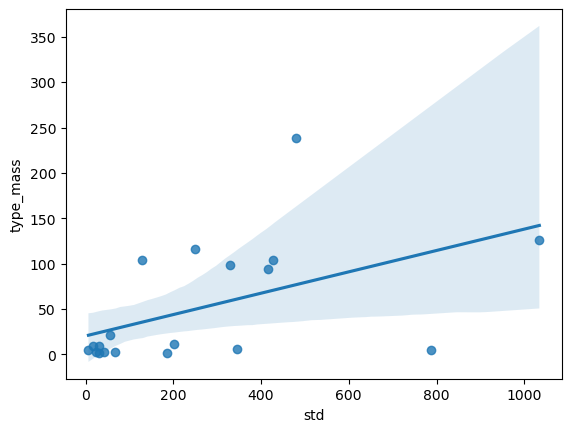

In [224]:
sns.regplot(data=pd.merge(df.query("not control").groupby("to_base_phones").matches_next_phoneme_target_rank.agg(["mean", "std"]).sort_values("std"),
         cohort_type_mass.rename("type_mass"), left_index=True, right_index=True),
         x="std", y="type_mass")

In [218]:
cohort_type_mass.sort_values()

base_phones
AY OW      2
Z AY       2
ER OW      3
AA F       3
W AW       3
EH TH      5
ER JH      5
AO G       6
ER EY      9
F UW       9
K OY      11
TH AH     21
K ER      94
L AY      98
R OW     104
K OW     104
P EY     116
P ER     126
AH N     238
Name: word, dtype: int64